In [1]:
import wfdb
import matplotlib.pyplot as plt
import os
from scipy import signal
import numpy as np
import tensorflow as tf
import pandas as pd

In [2]:
def rollingWindow(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [3]:
MIN_BPM = 30
MIN_FREQ = 300  # from inspection of '.hea' content
SAMPLE_WINDOW = int(60 / MIN_BPM * MIN_FREQ)
FIRST_WINDOW = int(SAMPLE_WINDOW / 2)  # avoid artifacts in the beginning of signal

In [4]:
t17 = pd.read_csv('./data/training2017/REFERENCE.csv', names=['id', 'type'])
t17['fname'] = './data/training2017/' + t17.id
t17['noisy'] = t17.type == '~'

saa = pd.read_csv('./data/set-a/RECORDS-acceptable', names=['id'])
saa['fname'] = './data/set-a/' + saa.id.astype(str)
saa['noisy'] = False
sau = pd.read_csv('./data/set-a/RECORDS-unacceptable', names=['id'])
sau['fname'] = './data/set-a/' + sau.id.astype(str)
sau['noisy'] = True
sa = pd.concat([saa, sau])

val = pd.read_csv('./data/validation/REFERENCE.csv', names=['id', 'type'])
val['fname'] = './data/validation/' + val.id
val['noisy'] = val.type == '~'

In [5]:
train_validate_noisy = []
train_validate_clean = []

for idx, row in t17.iterrows():
    data, info = wfdb.rdsamp(row['fname'])
    for sgnl in data.T:
        sgnl_wnd = rollingWindow(sgnl[FIRST_WINDOW:], SAMPLE_WINDOW)
        sgnl_picks = np.random.randint(0, sgnl_wnd.shape[0], [int(sgnl_wnd.shape[0] / SAMPLE_WINDOW * 0.5)])
        if row['noisy']:
            train_validate_noisy.append(sgnl_wnd[sgnl_picks])
        else:
            train_validate_clean.append(sgnl_wnd[sgnl_picks])
for idx, row in sa.iterrows():
    data, info = wfdb.rdsamp(row['fname'])
    for sgnl in data.T:
        sgnl_ds = signal.resample(sgnl, int(len(sgnl) / info['fs'] * MIN_FREQ))
        sgnl_wnd = rollingWindow(sgnl_ds[FIRST_WINDOW:], SAMPLE_WINDOW)
        sgnl_picks = np.random.randint(0, sgnl_wnd.shape[0], [int(sgnl_wnd.shape[0] / SAMPLE_WINDOW * 0.5)])
        if row['noisy']:
            train_validate_noisy.append(sgnl_wnd[sgnl_picks])
        else:
            train_validate_clean.append(sgnl_wnd[sgnl_picks])
train_validate_noisy = np.concatenate(train_validate_noisy, 0)
train_validate_clean = np.concatenate(train_validate_clean, 0)

test_noisy = []
test_clean = []
for idx, row in val.iterrows():
    data, info = wfdb.rdsamp(row['fname'])
    for sgnl in data.T:
        sgnl_wnd = rollingWindow(sgnl[FIRST_WINDOW:], SAMPLE_WINDOW)
        sgnl_picks = np.random.randint(0, sgnl_wnd.shape[0], [int(sgnl_wnd.shape[0] / SAMPLE_WINDOW * 0.5)])
        if row['noisy']:
            test_noisy.append(sgnl_wnd[sgnl_picks])
        else:
            test_clean.append(sgnl_wnd[sgnl_picks])
test_noisy = np.concatenate(test_noisy, 0)
test_clean = np.concatenate(test_clean, 0)

In [6]:
latent_dim = 2
inner_dim = 32

def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = tf.random.normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

# Encoder
input_x = tf.keras.layers.Input(shape= (SAMPLE_WINDOW, 1)) 
h = tf.keras.layers.LSTM(inner_dim)(input_x)  #, activation='relu'

# Z
z_mean = tf.keras.layers.Dense(latent_dim)(h)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(h)
z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_sigma])

# Decoder
decoder = tf.keras.layers.RepeatVector(SAMPLE_WINDOW)(z)
decoder = tf.keras.layers.LSTM(inner_dim, return_sequences=True)(decoder)  #, activation='relu'
decoder = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder)

def vae_loss(input_x, decoder, z_log_sigma, z_mean):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = tf.reduce_mean(tf.keras.metrics.binary_crossentropy(input_x, decoder))
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * tf.reduce_mean(tf.minimum(1e6, tf.exp(z_log_sigma)) + tf.square(z_mean) - 1. - z_log_sigma)

    return recon + kl

model = tf.keras.Model(input_x, decoder)
model.add_loss(vae_loss(input_x, decoder, z_log_sigma, z_mean))
model.compile(loss=None, optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))

In [7]:
trainX = train_validate_clean[..., np.newaxis].astype(np.float32)

In [8]:
BATCH_SIZE = 512
SHUFFLE_SIZE = BATCH_SIZE * 4

train_dataset = tf.data.Dataset.from_tensor_slices(trainX).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)

In [9]:
checkpoint_path = './mydata/vae/' + '{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(
    train_dataset,
    epochs=25,
    callbacks=[cp_callback])

Epoch 1/25
128/128 [==============================] - ETA: 0s - loss: -0.0950
Epoch 1: saving model to ./mydata/vae\0001.ckpt
128/128 [==============================] - 10s 55ms/step - loss: -0.0950
Epoch 2/25
127/128 [============================>.] - ETA: 0s - loss: -0.0752
Epoch 2: saving model to ./mydata/vae\0002.ckpt
128/128 [==============================] - 7s 55ms/step - loss: -0.1111
Epoch 3/25
127/128 [============================>.] - ETA: 0s - loss: -0.1077
Epoch 3: saving model to ./mydata/vae\0003.ckpt
128/128 [==============================] - 7s 54ms/step - loss: -0.1065
Epoch 4/25
127/128 [============================>.] - ETA: 0s - loss: -0.0662
Epoch 4: saving model to ./mydata/vae\0004.ckpt
128/128 [==============================] - 7s 54ms/step - loss: -0.0660
Epoch 5/25
127/128 [============================>.] - ETA: 0s - loss: -0.0622
Epoch 5: saving model to ./mydata/vae\0005.ckpt
128/128 [==============================] - 7s 54ms/step - loss: -0.0989
Epoch 6/2

In [10]:
pred_clean = model.predict(train_validate_clean[..., np.newaxis].astype(np.float32))

2041/2041 [==============================] - 84s 41ms/step


In [11]:
pred_noisy = model.predict(train_validate_noisy[..., np.newaxis].astype(np.float32))

127/127 [==============================] - 3s 21ms/step


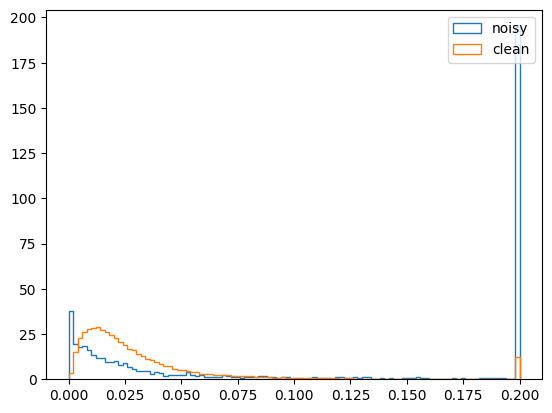

In [12]:
noisy_scores = np.square(train_validate_noisy[..., np.newaxis] - pred_noisy).mean(1)
clean_scores = np.square(train_validate_clean[..., np.newaxis] - pred_clean).mean(1)

noisy_scores[noisy_scores > 0.2] = 0.2
clean_scores[clean_scores > 0.2] = 0.2

hn = plt.hist(noisy_scores, bins=100, density=True, histtype='step', label='noisy')
hc = plt.hist(clean_scores, bins=100, density=True, histtype='step', label='clean')
plt.legend()

In [13]:
print(f"Noisy: {(np.square(train_validate_noisy[..., np.newaxis] - pred_noisy).mean(1) > 0.1).mean()*100:0.1f} %")
print(f"Clean: {(np.square(train_validate_clean[..., np.newaxis] - pred_clean).mean(1) < 0.1).mean()*100:0.1f} %")

Noisy: 44.5 %
Clean: 94.2 %


The above results demonstrate that the VAE:
1. Classifies 44.5 % of the subsignals in the noisy signals as anomalous or 'noisy'
2. Classifies 94.2% of the subsignals in the clean signals as clean

These results are comparable to the classifier in [ecgV1.ipynb](./ecgV1.ipynb), but I have not done much fine-tuning to this model yet.

It looks promising given that it has only been trained on the clean signals, which could also contain noisy segments. And vice-versa, the noisy signals could contain valid, clean subsignals.

A use of the VAE can be seen in [noisySegmentsVAE.ipynb](./noisySegmentsVAE.ipynb)